In [1]:
import pandas as pd
import numpy as np
from automation_process_dataV2 import united_functions
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
df_rating = pd.read_parquet('../../data/raw/data_model/ratings_train05.parquet')#Carga de datos

In [3]:
# muestrear 5% de regitros
_, subset_rating = train_test_split(df_rating, test_size=0.02, random_state=111)

In [4]:
subset_rating.reset_index(inplace=True, drop=True)

In [6]:
subset_rating.shape

(20001, 6)

In [7]:
df_processed, list_user_movies= united_functions(subset_rating)# Script de procesamiento de datos y retorno de titulo con id

INICIANDO PROCESAMIENTO DE DATOS...
- procesando tags y fusionando datasets..
- Eliminacion de nulos..
- Eliminando variables no necesarias...
- Extrayendo año del titulo...
- Almacenando en variable copia del df original...
- Extraemos los generos de cada pelicula...
- Eliminamos variables no necesarias...
- Codificamos los generos y normalizamos para su correcto formato...
FIN DE PROCESAMIENTO DE DATOS


In [8]:
df_processed.shape

(20000, 21)

In [11]:
# Diccionario de list_user_movies
dicc_user_movies = {'userId':list_user_movies['userId'], 'movieId':list_user_movies['movieId'], 'title':list_user_movies['title']}

In [14]:
# Arquitectura autoencoder
input_size = 1060
encoder = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size)
])
full_ae = tf.keras.Sequential([encoder,decoder])

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
full_ae.compile(loss='mse', optimizer=optimizer)# optimizador y funcion de perdida

In [16]:
history = full_ae.fit(df_processed, df_processed, epochs=5, batch_size=1,shuffle=True)

Epoch 1/5
68298/68298 [==============================] - 184s 3ms/step - loss: 0.0019
Epoch 2/5
68298/68298 [==============================] - 187s 3ms/step - loss: 0.0017
Epoch 3/5
68298/68298 [==============================] - 189s 3ms/step - loss: 0.0016
Epoch 4/5
68298/68298 [==============================] - 187s 3ms/step - loss: 0.0016
Epoch 5/5
68298/68298 [==============================] - 187s 3ms/step - loss: 0.0016


In [17]:
# grafico funcion perdida durante entrenamiento
def plot_model_loss (history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

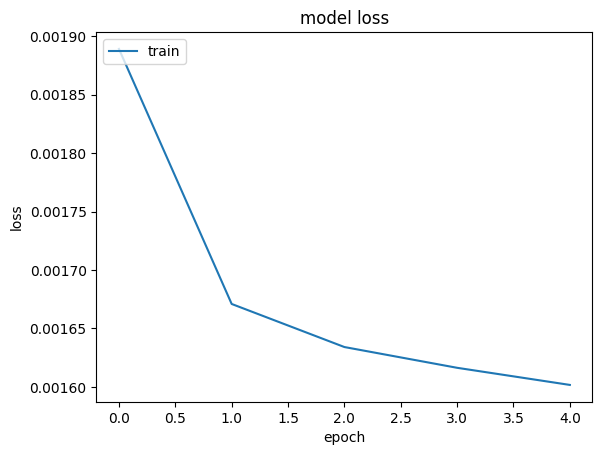

In [18]:
plot_model_loss (history)

In [17]:
# Guardar modelo V2
full_ae.save('models/model_ae_V2.0', save_format='tf')

INFO:tensorflow:Assets written to: models/model_ae_V2.0\assets


INFO:tensorflow:Assets written to: models/model_ae_V2.0\assets


In [11]:
# Cargar el modelo desde el formato SavedModel
full_ae = tf.keras.models.load_model('models/model_ae_V2.0')

In [22]:
full_ae.evaluate(df_processed,df_processed, batch_size=1)

46336/46336 [==============================] - 79s 2ms/step - loss: 0.0021


0.0020749056711792946

In [19]:
result_encoder = encoder.predict(df_processed)# resultado reducido dimensiones

2135/2135 [==============================] - 3s 2ms/step


In [20]:
result_encoder.shape

(68298, 128)

In [21]:
result_df = pd.DataFrame(result_encoder)# convertir resultado de prediccion a dataframe

Similitud del coseno (compara cada pelicula con todas las encontradas)

In [12]:
simil_cosine=cosine_similarity(df_processed)# calculo de similitus del coseno

In [13]:
# Rellenamos la diagonal con NaN y convertimos a dataframe
np.fill_diagonal(simil_cosine, np.nan)
df_similCosine = pd.DataFrame(simil_cosine)

Logica que implementa la recomendacion en base a un usuario y pelicula vista

In [15]:
def comprobar_existencia(diccionario, movie_id, user_id):    
    for i in range(len(diccionario['userId'])):
        if diccionario['userId'].iloc[i] == user_id and diccionario['movieId'].iloc[i] == movie_id:
            return True
    return False

In [16]:
def obtener_index_movieId(diccionario, movie_id):
    for i in range(len(diccionario['movieId'])):
        if diccionario['movieId'].iloc[i]==movie_id:
            index = i
            break
    return index

In [17]:
def get_title_from_movieId(user_id ,diccionario):
    index = diccionario['userId'].loc[diccionario['userId'] == user_id].index
    # Obtén los títulos de las películas
    titles_saws = diccionario['title'].loc[index]
    return titles_saws

In [35]:
# Funcion de recomendacion para un usuario y pelicula
def get_recommendations(user_id, movie_id,dicc_user_movies=dicc_user_movies, simil_cosine=df_similCosine, threshold=0.7):
    #Comprobamos que el usuario para la pelicula dada existe
    comprobar_user_movie_exist=comprobar_existencia(dicc_user_movies, movie_id, user_id)

    if comprobar_user_movie_exist:
       #Obtener indice de la pelicula dada
        index=obtener_index_movieId(dicc_user_movies, movie_id)

        # Obtén la lista de similitudes del coseno para una película y usuario dada
        cosine_sim_list = simil_cosine.iloc[index]
        
        # Ordena las películas en función de la similitud del coseno
        most_similar_movies_sorted=cosine_sim_list.sort_values(ascending=False)

        # Obtiene los índices de las 5 películas más similares superior al umbral 
        most_similar_movies = most_similar_movies_sorted[most_similar_movies_sorted > threshold][:5].index

        # Obtiene los títulos de las películas más similares
        most_similar_movie_titles = list(set([dicc_user_movies['title'][id] for id in most_similar_movies if id in dicc_user_movies['title']]))
        
        # Obtener los titulos de todas las peliculas vistas por el usuario
        titles_saws = get_title_from_movieId(user_id ,dicc_user_movies)
        titles_saws = list(titles_saws)
        
        # Pelicula actual pasada por parametros (title)
        actual_title = dicc_user_movies['movieId'].loc[dicc_user_movies['movieId'] == movie_id].index[0]

        print('Porque has visto:',dicc_user_movies['title'].loc[actual_title])
        
        # Filtra las películas recomendadas para excluir las que el usuario ya ha visto
        recommended_movies = [movie for movie in most_similar_movie_titles if movie not in titles_saws]

        # Si las peliculas se devuelven vacias se retorna la condicion
        if not recommended_movies:
            return 'No se encontro una pelicula lo suficientemente significativa para recomendar'
        print('Recomendamos:')
        return recommended_movies
    else: 
        return 'No se encontro usuario para pelicula dada'
        

In [55]:
result_recommendation=get_recommendations(35192,2012)#userId, movieId
result_recommendation

Porque has visto: Back to the Future Part III
Recomendamos:


['Zoolander']

In [53]:
list_user_movies.tail(10)

,userId,movieId,rating,title
19991,92360.0,4816,3.0,Zoolander
19992,35192.0,2012,3.0,Back to the Future Part III
19993,91709.0,1499,2.5,Anaconda
19994,22337.0,1090,3.5,Platoon
19995,136540.0,36,3.0,Dead Man Walking
19996,44535.0,38388,2.5,Goal! The Dream Begins
19997,136429.0,315,4.0,"Specialist, The"
19998,39514.0,354,3.0,Cobb
19999,106343.0,377,5.0,Speed
20000,138459.0,39444,4.0,"Weather Man, The"


In [22]:
# Buscar usuarios 
def movies_peruser(idUser):    
    print(list_user_movies[list_user_movies['userId']==idUser])

In [54]:
movies_peruser(35192)

        userId  movieId  rating                        title
19992  35192.0     2012     3.0  Back to the Future Part III
